In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.3 MB/s eta 0:00:00


In [ ]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2
import os
import pandas as pd
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/brain_mri'
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))


['yes', '.ipynb_checkpoints', 'no']
98


In [ ]:
classes = ['no','yes']
def cs_images(path,classes):
    imag = []
    label = []
    for i in classes:
        l1 = os.listdir(path+'/'+i)
        for j in l1:
            img = Image.open(path+'/'+i+'/'+j)
            img = img.resize(size = (30,30))
            img = img.convert('L')
            #img = img.reshape(50,50,1)
            #img = img.flatten()
            img = np.array(img)
            img = img.reshape(30,30,1)
            imag.append(img)
            label.append(classes.index(i))
            del(img)
    %matplotlib inline
    plt.figure(figsize=(10, 10))
    for i in range(20):
        plt.subplot(5,4,i+1)
        plt.imshow(imag[i], cmap="gray")
        plt.axis('off')
    plt.show()
    return np.array(imag),label

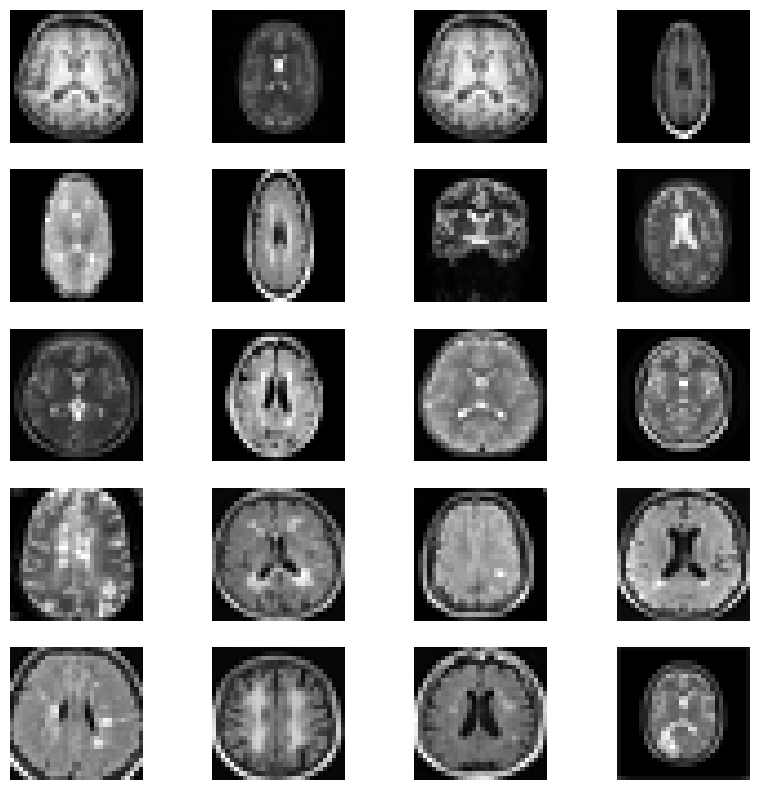

In [ ]:
x,y = cs_images('/content/drive/MyDrive/brain_mri',classes)

In [ ]:
x.shape


(98, 30, 30, 1)

In [ ]:
s = pd.Series(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,s,test_size = 0.1,random_state = 1,shuffle = True)

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "/content/drive/MyDrive/quanvolution" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)

In [ ]:
x_train = np.array(x_train[..., tf.newaxis], requires_grad=False)
x_test = np.array(x_test[..., tf.newaxis], requires_grad=False)

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


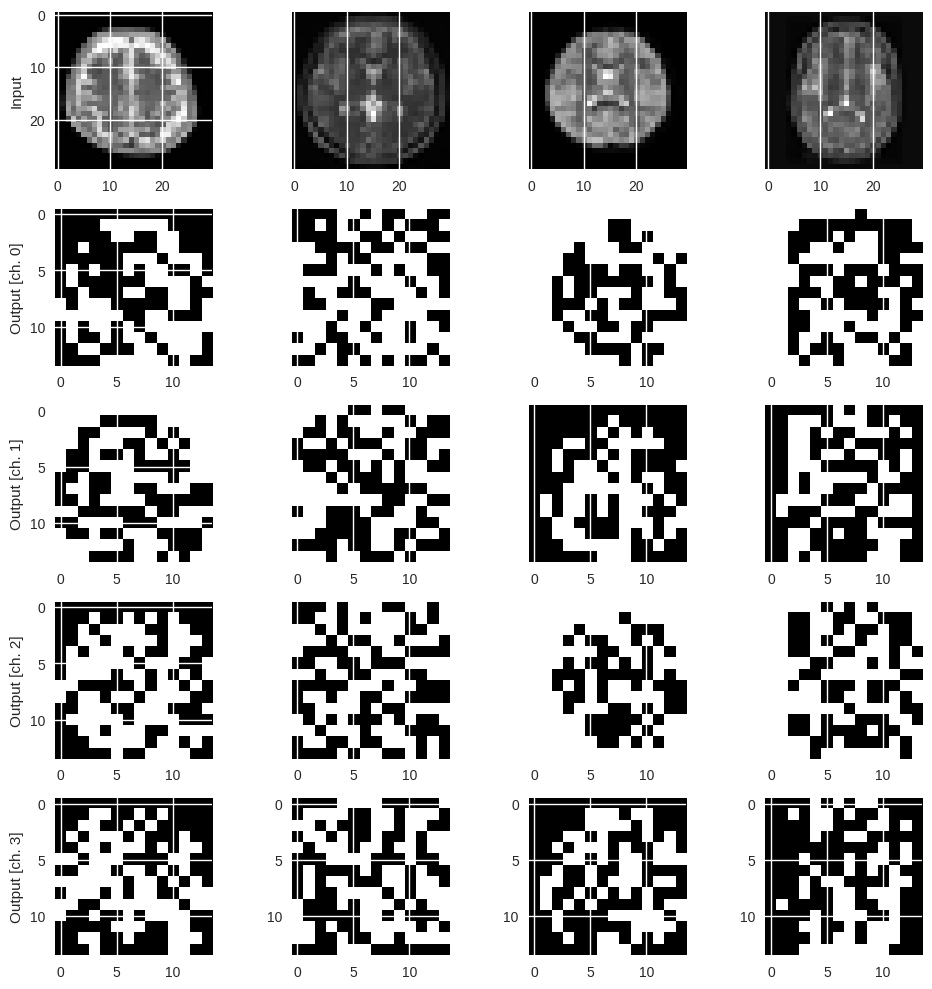

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    y_train,
    validation_data=(q_test_images, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
22/22 - 1s - loss: 1.6937 - accuracy: 0.4659 - val_loss: 1.0767 - val_accuracy: 0.7000 - 594ms/epoch - 27ms/step
Epoch 2/30
22/22 - 0s - loss: 0.7487 - accuracy: 0.8636 - val_loss: 0.9122 - val_accuracy: 0.7000 - 63ms/epoch - 3ms/step
Epoch 3/30
22/22 - 0s - loss: 0.4334 - accuracy: 0.9432 - val_loss: 0.8452 - val_accuracy: 0.7000 - 65ms/epoch - 3ms/step
Epoch 4/30
22/22 - 0s - loss: 0.2578 - accuracy: 0.9886 - val_loss: 0.8047 - val_accuracy: 0.7000 - 82ms/epoch - 4ms/step
Epoch 5/30
22/22 - 0s - loss: 0.1724 - accuracy: 0.9886 - val_loss: 0.7794 - val_accuracy: 0.7000 - 79ms/epoch - 4ms/step
Epoch 6/30
22/22 - 0s - loss: 0.1158 - accuracy: 1.0000 - val_loss: 0.7560 - val_accuracy: 0.7000 - 83ms/epoch - 4ms/step
Epoch 7/30
22/22 - 0s - loss: 0.0868 - accuracy: 1.0000 - val_loss: 0.7378 - val_accuracy: 0.7000 - 79ms/epoch - 4ms/step
Epoch 8/30
22/22 - 0s - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.7282 - val_accuracy: 0.7000 - 66ms/epoch - 3ms/step
Epoch 9/30
22/22 - 0s 

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
22/22 - 1s - loss: 1.9672 - accuracy: 0.9545 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 782ms/epoch - 36ms/step
Epoch 2/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 108ms/epoch - 5ms/step
Epoch 3/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 84ms/epoch - 4ms/step
Epoch 4/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 89ms/epoch - 4ms/step
Epoch 5/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 101ms/epoch - 5ms/step
Epoch 6/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 86ms/epoch - 4ms/step
Epoch 7/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 86ms/epoch - 4ms/step
Epoch 8/30
22/22 - 0s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_a

<ipython-input-68-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


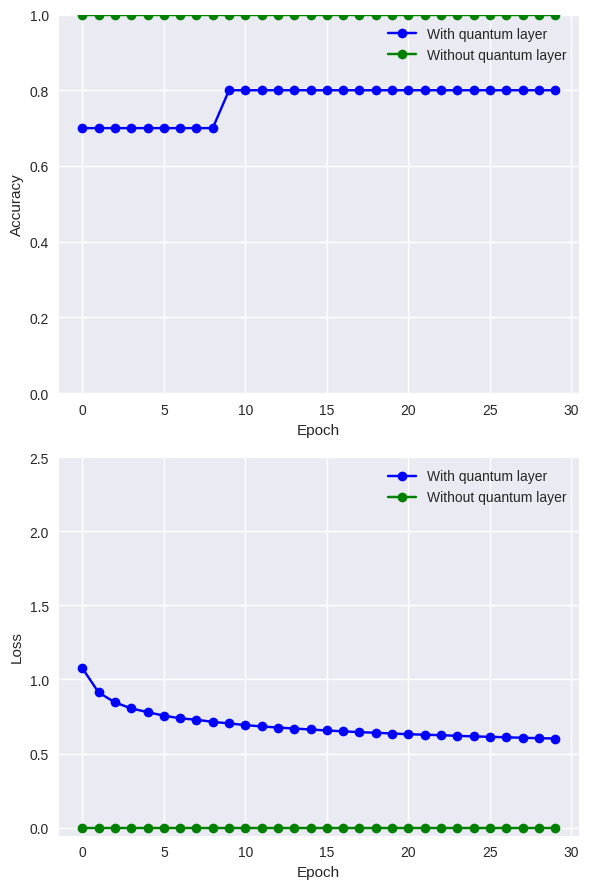

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
